<a href="https://colab.research.google.com/github/buzo14/sales-forecasting-model/blob/master/sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, we will be forcasting sales for an Ecuadorian Store. This datasets are from a kaggle competition and will be downloaded into our workspace using a key.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"henryochiabuto","key":"ce8af37b0718cba3f3046a0b321bc303"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
!kaggle competitions download -c store-sales-time-series-forecasting

 47% 10.0M/21.4M [00:00<00:00, 39.4MB/s]
100% 21.4M/21.4M [00:00<00:00, 60.5MB/s]


File was downloaded as a zipfile, so will need to be unzipped and files extracted using a zipfile library.


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/store-sales-time-series-forecasting.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import pandas as pd

holiday = pd.read_csv('/content/holidays_events.csv', parse_dates=['date'])
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
oil = pd.read_csv('/content/oil.csv', parse_dates=['date'])
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [7]:
# rename column to 'price'
oil.rename(columns={"dcoilwtico": "price"}, inplace=True)

In [8]:
stores = pd.read_csv('/content/stores.csv')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
train = pd.read_csv('/content/train.csv', parse_dates=['date'])
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [10]:
test = pd.read_csv('/content/test.csv', parse_dates=['date'])
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [11]:
transaction = pd.read_csv('/content/transactions.csv', parse_dates=['date'])
transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


# Data Preprocessing

In [45]:
# print helper function

def hprint(title, *args):
    print(title, *args, sep="\n")

Taking a look at the Train dataset, with the sales column being our target series, let's explore further the family and store_nbr columns.

In [46]:

num_family = train.family.nunique()
num_store = train.store_nbr.nunique()
num_ts = train.groupby(["store_nbr", "family"]).ngroups

hprint(
    f"Number of family types      : {num_family}",
    f"Number of stores            : {num_store}",
    f"Number of store-family pairs: {num_family * num_store}"
)


Number of family types      : 33
Number of stores            : 54
Number of store-family pairs: 1782


Next, we explore the date columns for both the Train and Test dataset. Here, we try to find any missing gaps in view of digging further to better understand the data.

In [47]:
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_len = (train_end - train_start).days + 1

test_start = test.date.min().date()
test_end = test.date.max().date()
num_test_date = test.date.nunique()
test_len = (test_end - test_start).days + 1

hprint(
    f"Number of unique train dates: {num_train_date}",
    f"Train date range            : {train_len} days from {train_start} to {train_end}",
    f"Number of unique test dates : {num_test_date}",
    f"Test date range             : {test_len} days from {test_start} to {test_end}",
)

Number of unique train dates: 1688
Train date range            : 1688 days from 2013-01-01 to 2017-08-15
Number of unique test dates : 16
Test date range             : 16 days from 2017-08-16 to 2017-08-31


Let's find the 4 missing dates for the Train dataset.

In [48]:
missing_dates = pd.date_range(train_start, train_end).difference(train.date.unique())

missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

hprint(f"Missing dates  : {missing_dates}")

Missing dates  : []


It turns out that all the target series for our Train dataset have missing dates on Christmas across the years, which suggests that the stores could be closed on this day.

To address this problem, we fill the missing dates by reindexing our training data, and then fill the sales and onpromotion columns with 0s to indicate that there are no sales/promotions since the stores are closed.

In [49]:

multi_idx = pd.MultiIndex.from_product([pd.date_range(train_start, train_end), train.store_nbr.unique(), train.family.unique()],
            names=["date", "store_nbr", "family"], )

train = train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()


train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.)

train.id = train.id.interpolate(method="linear") # interpolate linearly as a filler for the 'id'

Next, we take a look at the oil dataset and check for missing data.

In [50]:
missing_oil_dates = pd.date_range(train_start, test_end).difference(oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_wknd_missing = (missing_oil_dates.weekday >= 5).sum()

hprint(
    f"Number of missing oil dates: {num_missing_oil_dates}",
    f"Number of weekends missing : {num_wknd_missing}"
    )

Number of missing oil dates: 0
Number of weekends missing : 0


From the result and knowing that our grocery stores open on weekends, there is a need to estimate the missing oil prices if we are to use them in our models.

In [51]:

oil = oil.merge(pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
      on="date", how="outer").sort_values("date", ignore_index=True)

# fill missing values using linear interpolation

oil.oil = oil.price.interpolate(method="linear", limit_direction="both")

<ipython-input-51-7aa137e7be42>:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  oil.oil = oil.price.interpolate(method="linear", limit_direction="both")


Moving on, let's take a look at the transactions dataset.

since we have 54 stores and 1,688 train data dates, we expect to have 91,152 records of transactions.

In [52]:
num_zero_sales = (train.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
total_trans_rec = num_store * train_len
curr_rec = len(transaction.index)
missing_rec = total_trans_rec - curr_rec - num_zero_sales

hprint(
    f"Correct number of records: {total_trans_rec}",
    f"Current number of trans_records: {curr_rec}",
    f"Number of zero sales     : {num_zero_sales}",
    f"Number of missing records: {missing_rec}"
)

Correct number of records: 91152
Current number of trans_records: 91152
Number of zero sales     : 7546
Number of missing records: -7546


However, this does not tally with the dataset given. We can easily check that the transaction data does not record days with zero sales, indicating that such days are generally not recorded. As such, for days with zero sales, we fill the transactions column with 0s.

After doing that, we observe that there are still missing values, suggesting that there are indeed missing data entries not due to zero sales. For simplicity, we fill the remaining missing values using linear interpolation.

In [53]:
# compute total sales for each store
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# reindex transaction data
transaction = transaction.merge(
                store_sales,
                on=["date", "store_nbr"],
                how="outer").sort_values(["date", "store_nbr"], ignore_index=True)

# fill missing values with 0s for days with zero sales
transaction.loc[transaction.sales.eq(0), "transactions"] = 0.
transaction = transaction.drop(columns=["sales"])

# fill remaining missing values using linear interpolation
transaction.transactions = transaction.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)
transaction.head()

,date,store_nbr,transactions
0,2013-01-01,1,0.0
1,2013-01-01,2,0.0
2,2013-01-01,3,0.0
3,2013-01-01,4,0.0
4,2013-01-01,5,0.0


In [54]:
transaction.shape

(91152, 3)

For our holiday data, we note that there are holidays on different scales (national, regional and local).

National holidays correspond to country level, regional holidays to the state level, and local holidays to city level.


In [55]:
holiday[['type', 'locale']].value_counts(dropna=False)

type        locale  
Holiday     Local       133
Event       National     56
Holiday     National     52
Additional  National     40
Holiday     Regional     24
Additional  Local        11
Transfer    National      8
Bridge      National      5
Transfer    Local         4
dtype: int64

In [56]:
national_locale_name = sorted(holiday[holiday.locale.eq("National")].locale_name.unique().tolist())
regional_locale_name = sorted(holiday[holiday.locale.eq("Regional")].locale_name.unique().tolist())
local_locale_name = sorted(holiday[holiday.locale.eq("Local")].locale_name.unique().tolist())

hprint(
    f"National locale name(s): {national_locale_name}",
    f"Regional locale name(s): {regional_locale_name}",
    f"local locale name(s): {local_locale_name}"
)

National locale name(s): ['Ecuador']
Regional locale name(s): ['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas']
local locale name(s): ['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']


For national holidays, the locale_name always states the country, Ecuador. On the other hand, the values of locale_name can also be found in the state column for regional holidays. The same goes for local holidays with the city column. Because of this, we find out that not all cities have local holidays, and not all states have regional holidays.

In [57]:
holiday[(holiday.description.str.contains("Navidad"))&(holiday.date.dt.year.eq(2012))]

,date,type,locale,locale_name,description,transferred


In the holiday data, some days surrounding the actual holidays are also labeled as holidays, however these are further described under the 'type' & 'description' columns. We can check that in general, these surrounding days are labeled as 'Additional' in the type column. In addition, since Christmas 2012 falls on a Tuesday, 24 December 2012 is declared as a bridge holiday to make a long weekend. We can group such holidays together for standardization.

It turns out that there are other examples, such as the Independence Day for the different cities. For simplicity, we assume that such holidays should have similar impacts on the store sales. We assign the same labels for such holidays by removing extra words like bridge (puente) and the city/state names from the description column. The function to process the column is given below.

In [58]:
def transform_holiday(s):
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(stores.city.str.lower()) | set(stores.state.str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s

In [59]:
holiday.description = holiday.apply(
    lambda x: x.description.lower().replace(x.locale_name.lower(), ""),
    axis=1,
).apply(
    transform_holiday
).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,
).replace(
    r"\s+|-", " ", regex=True,
).str.strip()


holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False


We further transform the holiday data by removing holidays which are transferred. This is seen where the 'transferred' column says True.

 Since the holidays are not celebrated during the official date and are more like normal days, we exclude them.

In [60]:
holiday = holiday[holiday.transferred.eq(False)]

In [61]:
holiday[['type', 'locale']].value_counts()

type        locale  
Holiday     Local       133
Event       National     56
Holiday     National     52
Additional  National     40
Holiday     Regional     24
Additional  Local        11
Transfer    National      8
Bridge      National      5
Transfer    Local         4
dtype: int64

Next, we take a look at the 'Work Day' type and subsequently remove them

In [62]:
work_days = holiday[holiday.type.eq("Work Day")]
work_days

,date,type,locale,locale_name,description,transferred


In [63]:
work_days = work_days[["date", "type"]].rename(columns={"type": "work_day"}).reset_index(drop=True)

work_days.work_day = work_days.work_day.notna().astype(int)

# remove work days after extracting above
holiday = holiday[holiday.type!="Work Day"].reset_index(drop=True)

Next up, we separate them into national/regional/local holidays.

Prefixes nat_ / loc_ are set for national/local holidays to better differentiate them. For regional holidays, it turns out that we only have provincialization, so it is being labeled as such.

An example is shown below, where the national holidays are being encoded as dummy variables. The same applies for the other holidays.

In [64]:
# local holidays (city level)

local_holidays = holiday[holiday.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(columns={"locale_name": "city"}).reset_index(drop=True)

local_holidays = local_holidays[~local_holidays.duplicated()] # this code removes any duplicated rows in the local_holidays DataFrame
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")


In [65]:
local_holidays.head()

,date,city,loc_cantonizacion,loc_fundacion,loc_independencia
0,2012-03-02,Manta,0,1,0
1,2012-04-12,Cuenca,0,1,0
2,2012-04-14,Libertad,1,0,0
3,2012-04-21,Riobamba,1,0,0
4,2012-05-12,Puyo,1,0,0


In [66]:
# regional holidays (state level)

regional_holidays = holiday[holiday.locale.eq("Regional")]
regional_holidays.head()

,date,type,locale,locale_name,description,transferred
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
7,2012-06-25,Holiday,Regional,Imbabura,provincializacion,False
22,2012-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,provincializacion,False
23,2012-11-07,Holiday,Regional,Santa Elena,provincializacion,False
44,2013-04-01,Holiday,Regional,Cotopaxi,provincializacion,False


In [67]:
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(columns={"locale_name": "state", "description": "provincializacion"}).reset_index(drop=True)

regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

regional_holidays.head()

,date,state,provincializacion
0,2012-04-01,Cotopaxi,1
1,2012-06-25,Imbabura,1
2,2012-11-06,Santo Domingo de los Tsachilas,1
3,2012-11-07,Santa Elena,1
4,2013-04-01,Cotopaxi,1


In [68]:
# national holidays (country level)

national_holidays = holiday[holiday.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)

national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")

# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito independencia,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [69]:
# shorten name for viz later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#Data Exlploration
After data preprocessing, we can now analyze our data and discover patterns using visualizations.

Before we do that, we reshape our data from the long form to the wide form, where each column corresponds to one time series. Either forms can be easier to work with in different situations. An example is shown below for our target series, where the index is the time dimension represented by date and the columns are the sales for each store-family pair.

In [70]:
sales_ts = pd.pivot_table(train, values="sales", index="date", columns=["store_nbr", "family"])
tr_ts = pd.pivot_table(transaction, values="transactions", index="date", columns="store_nbr")
promo_ts = pd.pivot_table(train, values="onpromotion", index="date", columns=["store_nbr", "family"])

sales_ts.head()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

store_nbr                                        ...        54          \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   
2013-01-04         146.0          0.0                     0.0  26.743   
2013-01-05         205.0          0.0                     0.0  31.118   

store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  
2013-01-04           38.0     0.0                        0.0     2.0  
2013-01-05           32.0     0.0                        0.0     1.0  

[5 rows x 1782 columns]

For viz purposes, there is a need to scale our data if we want to look at the average value of the sales column. This helps to balance the impact across all store-family pairs on the average value. The same applies for the transactions and onpromotion values.

We also convert back the scaled sales data to the long form and add the holiday columns to analyze the holiday effects later.

An additional column no_holiday is computed to indicate days without any holidays. This is important when we are comparing the store sales between holiday and non-holiday periods.

In [71]:
# scale target series

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

scaler = MinMaxScaler()
sales_ts_scaled = sales_ts.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(sales_ts_scaled)

# convert back to long form and add the holiday columns
holiday_sales_merged = sales_ts_scaled.melt(
    value_name="sales", ignore_index=False,
).reset_index().merge(
    stores, on="store_nbr", how="left",
    ).merge(
    work_days, on="date", how="left",
).merge(
    local_holidays, on=["date", "city"], how="left",
).merge(
    regional_holidays, on=["date", "state"], how="left",
).merge(
    national_holidays, on="date", how="left",
).fillna(0)

# include dummy variable for dates without any holidays
holiday_list = [col for col in holiday_sales_merged if col.startswith(("loc_", "nat_", "provincializacion"))]
holiday_sales_merged["no_holiday"] = holiday_sales_merged[holiday_list].sum(axis=1).eq(0).astype(int)

holiday_sales_merged.head()

,date,store_nbr,family,sales,city,state,type,cluster,work_day,loc_cantonizacion,...,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo,no_holiday
0,2013-01-01,1,AUTOMOTIVE,0.000000,Quito,Pichincha,D,13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,2013-01-02,1,AUTOMOTIVE,0.105263,Quito,Pichincha,D,13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2013-01-03,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2013-01-04,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2013-01-05,1,AUTOMOTIVE,0.263158,Quito,Pichincha,D,13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
plt.rcParams["font.size"] = 15
COLORS = list(sns.color_palette())

Dates with zero sales
Dates (excl. Christmas) with zero sales: ['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01']
Corresponding counts of zero sales     : [1765, 1732, 1759, 1753, 1754]
Total number of target series          : 1782


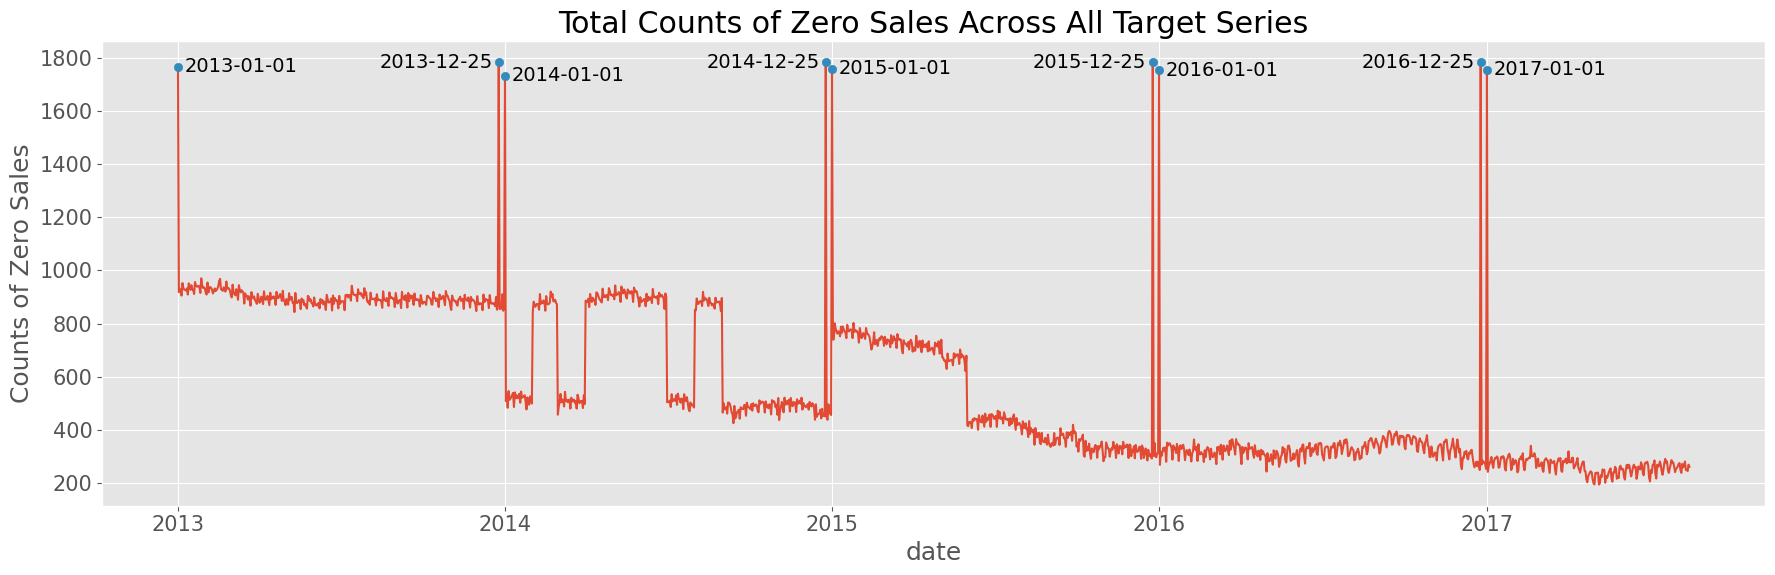

In [75]:
def plot_zero_count_ts():
    zero_count_ts = (sales_ts.eq(0)).sum(axis=1).to_frame("zero_sales_ct").reset_index() #count the number of zero sales
    zero_count_filtered = zero_count_ts[zero_count_ts.zero_sales_ct.gt(1500)].reset_index(drop=True)
    high_zero_dates = zero_count_filtered.date.dt.strftime("%Y-%m-%d")
    high_zero_dates = [d for d in high_zero_dates if not d.endswith("12-25")]
    high_zero_counts = zero_count_filtered[zero_count_filtered.date.isin(high_zero_dates)].zero_sales_ct.tolist()

    hprint(
        "Dates with zero sales",
        f"Dates (excl. Christmas) with zero sales: {high_zero_dates}",
        f"Corresponding counts of zero sales     : {high_zero_counts}",
        f"Total number of target series          : {num_ts}",
    )

    plt.figure(figsize=(18, 6))

    sns.lineplot(data=zero_count_ts, x="date", y="zero_sales_ct")
    sns.scatterplot(
        data=zero_count_filtered, x="date", y="zero_sales_ct",
        color=COLORS[1],
        edgecolor=COLORS[1],
        zorder=2,
    )
    for j in range(len(zero_count_filtered.index)):
        ha = "left" if j%2==0 else "right"
        offset = pd.Timedelta(7, "d") if ha=="left" else pd.Timedelta(-7, "d")

        plt.text(
            x=zero_count_filtered.date[j]+offset, y=zero_count_filtered.zero_sales_ct[j],
            s=zero_count_filtered.date[j].strftime("%Y-%m-%d"),
            ha=ha,
            va="center",
            size=14,
        )
    plt.ylabel("Counts of Zero Sales")
    plt.title("Total Counts of Zero Sales Across All Target Series")
    plt.tight_layout()
    plt.show()

plot_zero_count_ts()

We started off by counting the number of target series with zero sales for each day. The counts of zero sales has a general downward trend, suggesting that periods with no sales are becoming less frequent and that the stores are generating positive sales consistently. This could be due to changes in some covariates that have a temporal relationship with the sales numbers, which we will investigate later.

Besides Christmas, we also have large counts of zero sales on New Year's Day across the years. Similarly, many stores could be closed on this occasion, which we should take note of in our models later. Interestingly, there are great fluctations in the count of zero sales between 2014 and 2015.

Constant target series
Number of constant target series: 53
List of unique constant values  : [0.0]


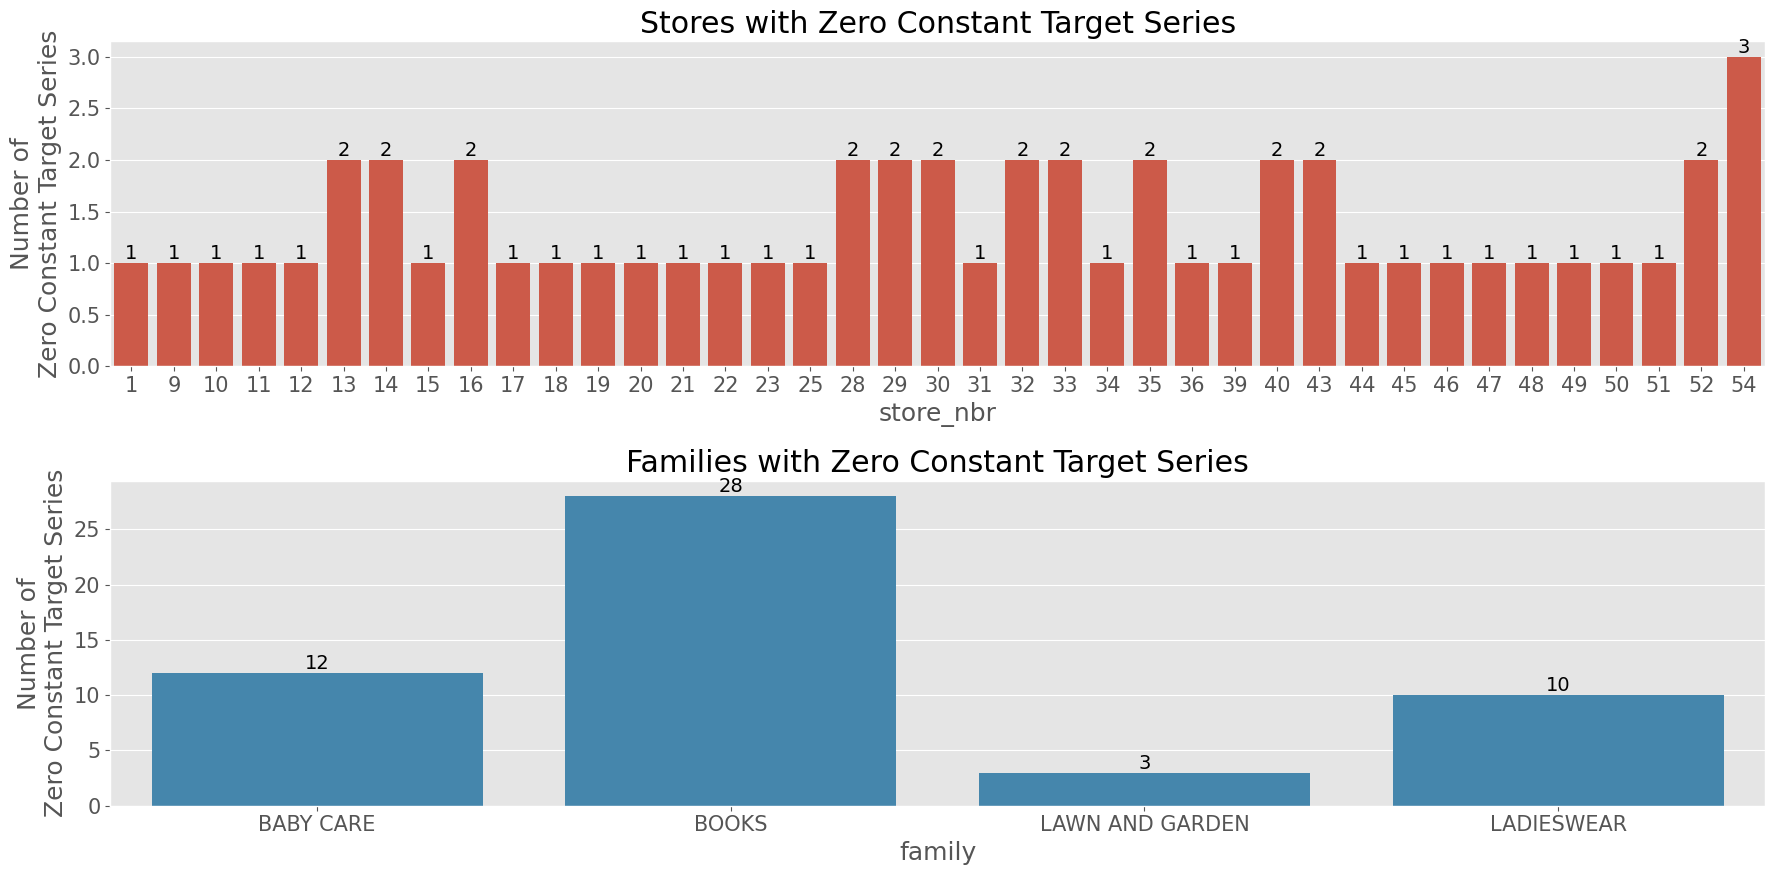

In [76]:
def plot_constant_ts_distribution():
    const_ts = sales_ts.iloc[:, (sales_ts.std()==0).tolist()]
    const_ts_labels = const_ts.columns.to_frame().reset_index(drop=True)

    hprint(
        "Constant target series",
        f"Number of constant target series: {len(const_ts.columns)}",
        f"List of unique constant values  : {const_ts.iloc[0].unique().tolist()}",
    )

    fig = plt.figure(figsize=(18, 9))

    ax0 = sns.countplot(
        data=const_ts_labels, x="store_nbr",
        color=COLORS[0],
        ax=fig.add_subplot(211),
    )
    ax0.bar_label(ax0.containers[0], size=14)
    plt.ylabel("Number of\nZero Constant Target Series")
    plt.title("Stores with Zero Constant Target Series")

    ax1 = sns.countplot(
        data=const_ts_labels, x="family",
        color=COLORS[1],
        ax=fig.add_subplot(212),
    )
    ax1.bar_label(ax1.containers[0], size=14)
    plt.ylabel("Number of\nZero Constant Target Series")
    plt.title("Families with Zero Constant Target Series")

    plt.tight_layout()
    plt.show()

plot_constant_ts_distribution()

Our training data has 53 target series with all values equal to zero. This could be due to poor sales performance or product unavailability.
What is interesting here is that all stores have about 0 to 3 zero constant target series.

If we consider this by the product family, books have the most number of zero constant target series. It appears that the problem of zero sales could be due to the type of product being sold.

#Model Training
Combining the datasets.¶

Now that we are done with our analysis, we proceed to train our models for forecasting. To prepare our data for training, we need to combine the relevant datasets and include the useful covariates as discussed previously. The steps taken are documented in the code below.

An additional step performed here is that for Christmas and New Year's Day, where most stores have zero sales (as they are likely closed), instead of filling the values with 0s, we temporarily set them to NaN and perform linear interpolation later. The reason for this is to treat such days as regular holidays, instead of having to include an additional variable to capture this unique behavior of store closure.